### AI61002 Project
# Bengali Digit Recognition in the Wild
#### Submitted By
# SHUBHRAJYOTI SARKAR
# 15PH20028

In [0]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from torchvision import transforms
import os, shutil, random, time, copy
from PIL import Image
import torchvision
from torchvision import transforms, datasets


# Used this Github handle for inversion transformation of images

In [47]:
!wget https://raw.githubusercontent.com/sebastianberns/torchvision.transforms.invert/master/invert.py

--2020-06-13 13:50:34--  https://raw.githubusercontent.com/sebastianberns/torchvision.transforms.invert/master/invert.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1312 (1.3K) [text/plain]
Saving to: ‘invert.py.2’

invert.py.2         100%[===================>]   1.28K  --.-KB/s    in 0s      

2020-06-13 13:50:34 (82.3 MB/s) - ‘invert.py.2’ saved [1312/1312]



In [0]:
from invert import Invert

# Used this repositery to print the summary of the model

In [49]:
!pip install torchsummary
from torchsummary import summary

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path = '/content/drive/My Drive/BengaliDRW'

## Data preprocessing

In [0]:
def makeDirectory (dir_path):
    if os.path.exists (dir_path):
        shutil.rmtree (dir_path)
    os.mkdir (dir_path)

#This code section was written to organize the data for my convenience.
This moves the classified images to separate forders according to their labels.
name of folders are name of labels.

In [0]:
# labels_file = os.path.join (data_path, 'labels.xls')
# full_data_path = os.path.join (data_path, 'full')
# if not os.path.exists (full_data_path):
#   os.mkdir (full_data_path)
# labels = pd.read_excel(labels_file,header=None)
# for i in range (len (labels)):
#   image_name = 'raw/' + labels.iloc[i, 0]+'.jpg'
#   image_label = labels.iloc[i, 1]
#   image_path = os.path.join (data_path, image_name)
#   target_dir_path = os.path.join (full_data_path, str (image_label))
#   # print (image_path, target_dir_path)
#   makeDirectory (target_dir_path)
#   shutil.copyfile (image_path, os.path.join (target_dir_path, image_name[4:]))
#   # os.system ('cp ' + image_path + ' ' + target_dir_path)

In [0]:
# for filename in os.listdir (data_path):
#   src_path = os.path.join (data_path, filename)
#   if (src_path.endswith ('.jpg')):
#     tgt_path = os.path.join (data_path, 'raw')
#     os.system ('mv ' + src_path + ' ' + tgt_path)

## Train - Val - Test Split

10% data for validation

10% data for test

80% data for training 

In [0]:
RATIO_VAL = 0.1
RATIO_TEST = 0.1

Declaration of paths

In [0]:
full_data_path = os.path.join (data_path, 'full')
train_data_path = os.path.join (data_path, 'train')
val_data_path = os.path.join (data_path, 'val')
test_data_path = os.path.join (data_path, 'test')

Making Respective directories

In [0]:
for dirname in (train_data_path, val_data_path, test_data_path):
    makeDirectory (dirname)

## Splitting

In [12]:
sumlen = 0
for label_dir in os.listdir (full_data_path):
    tgt_train = os.path.join (train_data_path, label_dir)
    tgt_val = os.path.join (val_data_path, label_dir)
    tgt_test = os.path.join (test_data_path, label_dir)
    for dirname in (tgt_train, tgt_val, tgt_test):
        makeDirectory (dirname)
    label_path = os.path.join (full_data_path, label_dir)
    list_images = os.listdir (label_path)
    random.shuffle (list_images)
    total = len (list_images)
    print (total)
    sumlen += total
    num_val = int(total * RATIO_VAL)
    num_test = int(total * RATIO_TEST)
    num_train = total - (num_val + num_test)
    train_images = list_images[ : num_train]
    val_images = list_images[ num_train : num_train + num_val]
    test_images = list_images[ num_train + num_val : ]
    for img in train_images:
        src_img = os.path.join (label_path, img)
        tgt_img = os.path.join (tgt_train, img)
        shutil.copyfile (src_img, tgt_img)
    for img in val_images:
        src_img = os.path.join (label_path, img)
        tgt_img = os.path.join (tgt_val, img)
        shutil.copyfile (src_img, tgt_img)
    for img in test_images:
        src_img = os.path.join (label_path, img)
        tgt_img = os.path.join (tgt_test, img)
        shutil.copyfile (src_img, tgt_img)
print (sumlen)

126
282
124
211
133
98
89
83
81
166
1393


# Data augmentation

## Color Inversion Augmentation

In [0]:

for label_dir in os.listdir (train_data_path):
    label_path = os.path.join (train_data_path, label_dir)
    for img_name in os.listdir (label_path):
        img_path = os.path.join (label_path, img_name)
        img = Image.open (img_path)
        inv = Invert()
        invertedImage = inv (img)
        inverted_path = os.path.join (label_path, 'inverted_' + img_name)
        invertedImage.save (inverted_path, 'JPEG')


# To handle the imbalance of Data classification I have augmented the data using rotation and translation transformation and created almost similar amount of data for all classes

In [0]:
translate_string = '3456789'
rotation_string = '789'

def rotation (img):
    return transforms.functional.affine(img, 15, (0, 0), 1, 0, resample=0, fillcolor=None)

def translation (img):
    return transforms.functional.affine(img, 0, (0.05, 0.05), 1, 0, 0, None)

for label_dir in os.listdir (train_data_path):
    label_path = os.path.join (train_data_path, label_dir)
    for img_name in os.listdir (label_path):
        img_path = os.path.join (label_path, img_name)
        img = Image.open (img_path)
        
        if label_dir in translate_string:
            # translate
            translated_image = translation (img)
            translated_path = os.path.join (label_path, 'translated_' + img_name)
            translated_image.save (translated_path, 'JPEG')

        if label_dir in rotation_string:
            #rotation
            rotated_image = rotation (img)
            rotated_path = os.path.join (label_path, 'rotated_' + img_name)
            rotated_image.save (rotated_path, 'JPEG')


## Preparation of datasets and dataloader for both training and validation

In [0]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale (1),
        transforms.Resize ((32, 32)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale (1),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]),
}

data_dir = data_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualizing a single batch

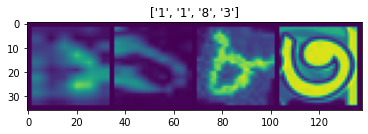

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp[:, :, 0]
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Define model architecture

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

### Train model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = dict()
    accuracies = dict()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase not in losses:
                losses[phase] = list()
                accuracies[phase] = list()

            losses[phase].append (epoch_loss)
            accuracies[phase].append (epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

#Making Model object

In [0]:
net = LeNet()

#Printing the structure of the Model

Reference: https://github.com/sksq96/pytorch-summary

In [59]:
my_model_structure = net.to(device)
summary(my_model_structure,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


# Training the model using SGD optimizer

In [64]:
print(net)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.002
num_epochs = 50
optimizer=optim.SGD(net.parameters(),lr=learning_rate)

trained_model, losses, accuracies = train_model(net, criterion, optimizer, optimizer, num_epochs)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/49
----------
train Loss: 2.3023 Acc: 0.1061
val Loss: 2.3007 Acc: 0.0889

Epoch 1/49
----------
train Loss: 2.2955 Acc: 0.1121
val Loss: 2.3061 Acc: 0.1185

Epoch 2/49
----------
train Loss: 2.2915 Acc: 0.1368
val Loss: 2.3107 Acc: 0.0593

Epoch 3/49
----------
train Loss: 2.2890 Acc: 0.1465
val Loss: 2.3148 Acc: 0.1630

Epoch 4/49
----------
train Loss: 2.2870 Acc: 0.1584
val Loss: 2.3140 Acc: 0.2222

Epoch 5/49
----------
train Loss: 2.2843 Acc: 0.1683
val Loss: 2.3092 Acc: 0.2222

Epoch 6/49
--------

#Ploting the performance

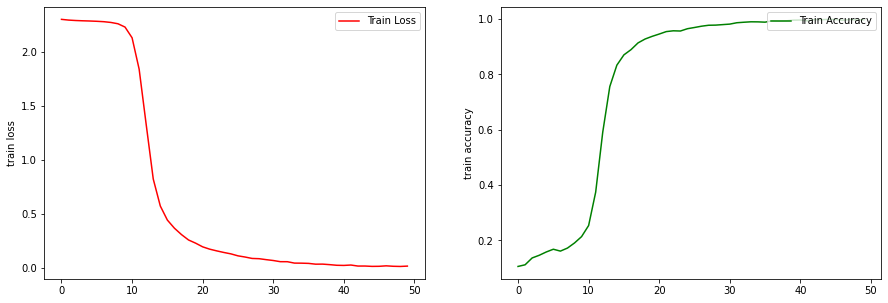

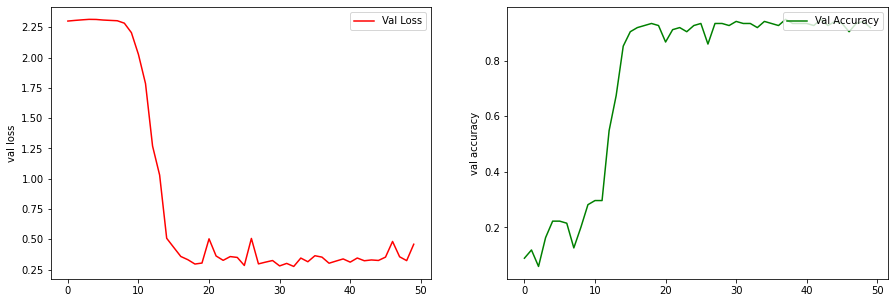

In [65]:

for phase in ('train', 'val'):
    fig = plt.figure(figsize=[15,5]) 
    plt.subplot(121)
    plt.plot(range(len(losses[phase])),losses[phase],'r-',label=phase.capitalize() + ' Loss') 
    plt.legend(loc='upper right')
    #vplt.xlabel('Mini Batch')
    plt.ylabel(phase + ' loss')
    plt.subplot(122)
    plt.plot(range(len(accuracies[phase])),accuracies[phase],'g-',label=phase.capitalize() + ' Accuracy') 
    plt.legend(loc='upper right')
    # plt.xlabel('Mini Batch')
    plt.ylabel(phase + ' accuracy')
             

### Evaluation of trained model

In [0]:
#Preparation of test_dataset and testLoader
test_data_transforms = transforms.Compose (
    [
        transforms.Grayscale (1),
        transforms.Resize ((32, 32)),
        transforms.ToTensor(),
    ]
)

data_dir = data_path
test_dataset = datasets.ImageFolder (os.path.join (data_dir, 'test'), test_data_transforms)
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=4)
test_dataset_size = len(test_dataset)

In [67]:
correct_pred = 0
for data in testLoader:
    inputs, labels = data
    # Feedforward train data batch through model
    output = trained_model(inputs)
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item() / test_dataset_size
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  94.81481481481482
